In [1]:
import sys
sys.path.append('/home3/ebrahim/isr/')
from matplotlib import pyplot as plt
%matplotlib inline
from RNNcell import RNN_one_layer, RNN_two_layers, RNN_output_integrator
from datasets import OneHotLetters, OneHotLetters_test
from run_test_trials import run_test_trials
from simulation_one import simulation_one
from scipy import spatial
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import numpy as np
import wandb
device = torch.device("cuda:0")
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import r2_score
import pandas as pd
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# load model
mi = 5
base = '/home3/ebrahim/isr/saved_models/'
runPATH = ["ebrahimfeghhi/isr/nqhjl1rf",  "ebrahimfeghhi/isr/q2gm7u57", "ebrahimfeghhi/isr/4fctnfce", 
            "ebrahimfeghhi/isr/lgt9du7n", "ebrahimfeghhi/isr/0dbbarfu", "ebrahimfeghhi/isr/uds94i6t"]
modelPATH = ['hs_200_noise_0.0_opt_ADAM_no_o2h/model_human.pth', "hs_200_noise_2.2_opt_ADAM_mom_0.0_2/model_human.pth",
             'hs_100_noise_0.0_opt_ADAM/model_human.pth', 'feedback_onehot_26_letters/model_human.pth', 'feedback_onehot_noise_2.0/model_human.pth',
             'feedback_onehot_26_SGD/model_human.pth']
api = wandb.Api()
run = api.run(runPATH[mi])
config = run.config
saved_info = torch.load(base + modelPATH[mi])
model = RNN_one_layer(config['num_letters']+1, config['hs'], config['num_letters']+1, noise_std=config['noise_std'], feedback_bool=True)
model.load_state_dict(saved_info['model_state_dict'])

<All keys matched successfully>

In [3]:
# Make sure accuracy values look right 
try:
    run_test = run_test_trials(model, .5)
    run_test.checkpoint(config, device, 1, '/home3/ebrahim/isr/')
except:
    config['test_path_lists'] = 'test_set/test_lists_dict_10.pkl'
    run_test = run_test_trials(model, .5)
    run_test.checkpoint(config, device, 1, '/home3/ebrahim/isr/')

run_test.accuracy_dict

{'2': 1.0,
 '3': 0.89282,
 '4': 0.84754,
 '5': 0.72074,
 '6': 0.54825,
 '7': 0.3036,
 '8': 0.092,
 '9': 0.0052}

In [8]:
# Run sim_one_code
sim_one = simulation_one(model, 9, 0.5, 6, fb_type=1)
sim_one.run_model(device, 6, config, base='/home3/ebrahim/isr/')
print(sim_one.relative_error_ratio)
print(sim_one.R_E)
print(sim_one.R_T)
print(sim_one.ARD)
print(sim_one.relative_errors_subset)
print(sim_one.fill_in_errors / sim_one.report_early)
print(sim_one.relative_errors_subset / sim_one.report_early)

0.116
0.058
0.066
3.359
366
0.8036907413299396
0.11644925230671332


In [14]:
# find trials with 1 repitition, distance 1, and no other errors
rep_dist = np.asarray(sim_one.repitition_distances)
print("Number of repititions: ", rep_dist.shape[0])
rep_trials = sim_one.repitition_trials
h = sim_one.h_stacked
y_hat_recall = sim_one.y_hat_recall.cpu().numpy()
y_hat = sim_one.y_hat.cpu().numpy()
softmax_probs = np.round(sim_one.softmax_probs.numpy(),3)
y_target_recall = sim_one.y_test_recall.cpu().numpy()
h = sim_one.h_stacked.cpu().numpy()
trials_with_1rep_dist1 = []
for key in rep_trials:
    # select trials with 1 repitition error and with an ARD of 1 
    if len(rep_trials[key]) == 1 and rep_trials[key][0] == 1:
        # store index of the trial 
        trials_with_1rep_dist1.append(key)

# select hidden activity and predictions 
y_hat_rep_trials_1 = y_hat[trials_with_1rep_dist1].squeeze()
y_hat_rep_trials_1_recall = y_hat_rep_trials_1[:, 6:]
softmax_probs_rep_trials_1 = softmax_probs[trials_with_1rep_dist1].squeeze()
y_target_rep_trials_1 = y_target_recall[trials_with_1rep_dist1].squeeze()
h_rep_trials_1 = h[:, trials_with_1rep_dist1, :]

# filter out trials that have other types of errors 
one_error_trials = []
location_of_rep_errors = []
for i, errors in enumerate(y_target_rep_trials_1 - y_hat_rep_trials_1_recall):
    if np.argwhere(errors!=0).shape[0] == 1:
        location_of_rep_errors.append(np.argwhere(errors!=0)[0][0])
        one_error_trials.append(i)

y_hat_rep_trials_1error = y_hat_rep_trials_1_recall[one_error_trials].squeeze()
softmax_probs_1error = softmax_probs_rep_trials_1[one_error_trials].squeeze()
h_1error = h[:, one_error_trials, :]
assert y_hat_rep_trials_1error.shape[0] == h_1error.shape[1], print("Shape mismatch")
print("Number of trials with 1 repitition (dist 1) that is the only error")

Number of repititions:  1017
Number of trials with 1 repitition (dist 1) that is the only error


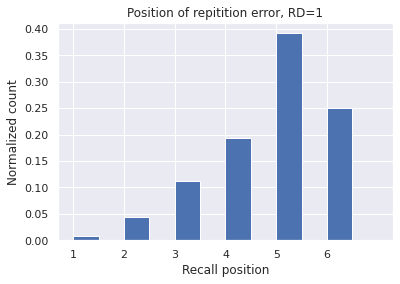

In [15]:
# Visualize distribution of recall positions where repitition error (RE) occurred
# RD stands for repitition distance
sns.set_theme()
plt.title("Position of repitition error, RD=1")
plt.xlabel("Recall position")
plt.ylabel("Normalized count")
plt.hist(np.asarray(location_of_rep_errors)+1, 
                    bins=[1,2,3,4,5,6,7], width=.5, density=True)
plt.xticks([1,2,3,4,5,6])
plt.show()

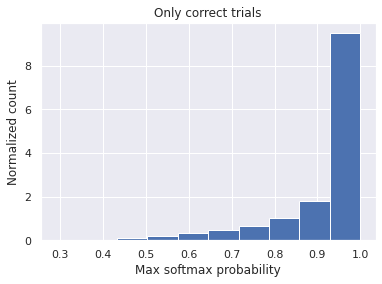

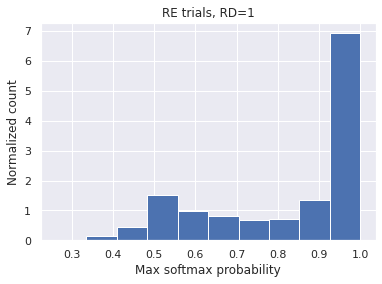

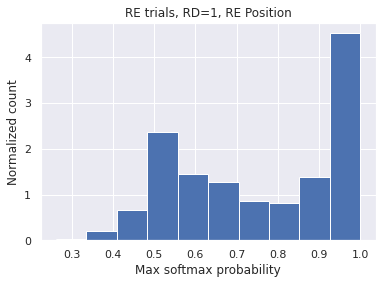

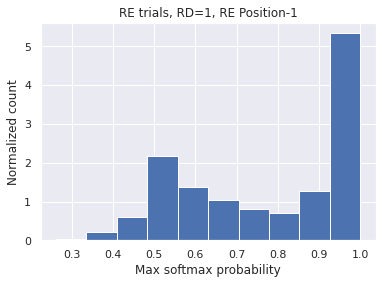

In [17]:
# analyzing softmax probabilities
correct_trials = sim_one.correct_trials()
softmax_probs_correct_trials = softmax_probs[correct_trials].squeeze()
max_prob = np.max(softmax_probs_correct_trials, axis=2)
plt.hist(max_prob.ravel(), density=True)
plt.title("Only correct trials")
plt.xlabel("Max softmax probability")
plt.ylabel("Normalized count")
plt.show()

max_prob_1error = np.max(softmax_probs_1error, axis=2)
plt.hist(max_prob_1error.ravel(), density=True)
plt.title("RE trials, RD=1")
plt.xlabel("Max softmax probability")
plt.ylabel("Normalized count")
plt.show()

max_prob_1error_rep = np.max(softmax_probs_1error[:, np.asarray(location_of_rep_errors), :],axis=2)
plt.hist(max_prob_1error_rep.ravel(), density=True)
plt.title("RE trials, RD=1, RE Position")
plt.xlabel("Max softmax probability")
plt.ylabel("Normalized count")
plt.show()


max_prob_1error_rep = np.max(softmax_probs_1error[:, np.asarray(location_of_rep_errors)-1, :],axis=2)
plt.hist(max_prob_1error_rep.ravel(), density=True)
plt.title("RE trials, RD=1, RE Position-1")
plt.xlabel("Max softmax probability")
plt.ylabel("Normalized count")
plt.show()


In [55]:
max_prob.shape

(2832, 1, 11)

[0 6 6 1 3 7]


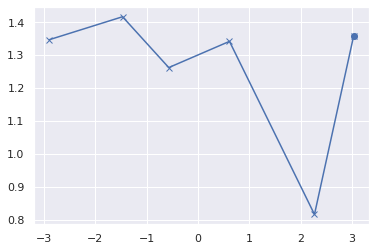

In [129]:
i = 6
plt.plot(h_2d[0, i, 0], h_2d[0, i, 1], marker='o', color='b')
plt.plot(h_2d[:, i, 0], h_2d[:, i, 1], marker='x')
print(y_hat_rep_trials_1error[i])

In [6]:
def predict_n_back(h_t, y_t, t, process_data=True, seed=0):

    '''
    Predict the letter at time t given the hidden state at time t+n.
    For now, we'll do this using only the recall portion. 
    @param h (np array): RNN hidden activity (recall_timesteps x trials x units)
    @param y (np array): letters that were fed to RNN to generate hidden activity (trials x letters)
    @param n (int): number of timesteps back to predict
    '''

    if process_data:
        h_t = np.vstack(h_t[:, t:]) # select hidden activty from timestep n and beyond
        if t != 0:
            y_t = np.hstack(y_t[:, :-t]) # select letters up to timestep n
        else:
            y_t = np.hstack(y_t)

    # select 60% of trials for training
    rng = np.random.default_rng(seed)
    train_ind = rng.choice(y_t.shape[0], int(y_t.shape[0]*.8), replace=False)
    test_ind = np.setdiff1d(np.arange(0,y_t.shape[0],1), train_ind) 

    log_reg = LogisticRegression(solver='liblinear').fit(h_t[train_ind], y_t[train_ind])

    y_hat = log_reg.predict(h_t[test_ind])
    r2_score_value = r2_score(y_t[test_ind], y_hat)

    return r2_score_value 

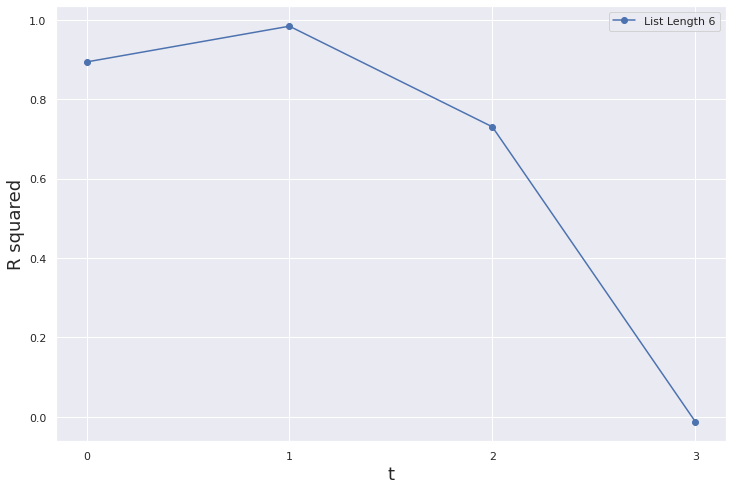

In [42]:
plt.figure(figsize=(12,8))
sns.set_theme()
n_range = [6]
for n in n_range:
    r2_score_vals = []
    # load RNN activity and letters for lists of length n
    run_test.run_model(device, n, config, base='/home3/ebrahim/isr/')
    h_test_n_recall = run_test.h_stacked[n:].cpu().numpy().swapaxes(0,1)
    y_pred_n_recall = run_test.y_hat_recall.numpy()
    correct_trial_indices = run_test.correct_trials()
    for t in range(4):
        r2_score_val = predict_n_back(h_test_n_recall, y_pred_n_recall, t)
        r2_score_vals.append(r2_score_val)

    # plot r2 score values 
    plt.plot(np.arange(4), r2_score_vals, marker='o', label="List Length " + str(n))
    plt.xlabel("t", fontsize=18)
    plt.ylabel("R squared", fontsize=18)
    plt.xticks(np.arange(4))

plt.legend()
plt.savefig('/home3/ebrahim/isr/isr_figures/tback_hs_100_noise_0_opt_ADAM', dpi=400, bbox_inches='tight')
plt.show()

In [13]:
for name, param in model.named_parameters():
    if name == 'RNN.i2h.weight':
        i2h = param.detach().cpu().numpy()
    if name == 'RNN.h2h.weight':
        h2h = param.detach().cpu().numpy()
    if name == 'RNN.h2h.bias':
        h2h_bias = param.detach().cpu().numpy()
    if name == 'h2o.weight':
        h2o = param.detach().cpu().numpy()
    if name == 'h2o.bias':
        h2o_bias = param.detach().cpu().numpy()
    if name == 'RNN.o2h.weight':
        o2h = param.detach().cpu().numpy()

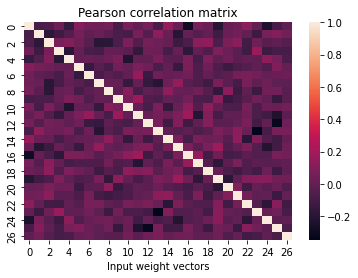

In [17]:
i2h_corr = np.zeros((i2h.shape[1], i2h.shape[1]))
sig_corrs = []
for i in range(i2h.shape[1]):
    for j in range(i2h.shape[1]):
        if i == j: 
            i2h_corr[i,j] = 1.0
        else:
            r,p = pearsonr(i2h[:, i], i2h[:, j])
            if p < 0.05 and i != 10 and j != 10:
                sig_corrs.append(round(r,3))
            i2h_corr[i,j] = r

sns.heatmap(i2h_corr)
plt.xlabel("Input weight vectors")
plt.title("Pearson correlation matrix")
plt.show()

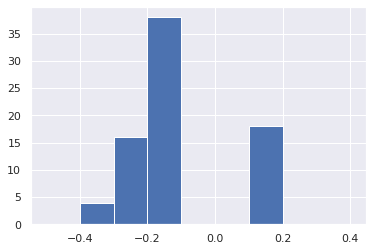

In [22]:
sns.set_theme()
plt.hist(sig_corrs, bins=np.arange(-.5,.5,.1))
plt.show()

In [34]:
ct = y_pred_n_recall[correct_trial_indices].squeeze()
ct[20]

array([0, 1, 7, 8, 5, 6])

In [9]:
A = torch.tensor([[0.8, 0.1, 0.05, 0.05], [0.2, 0.2 ,0.2, 0.4]])
torch.nn.functional.one_hot(torch.argmax(A, dim=1), num_classes=11)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])